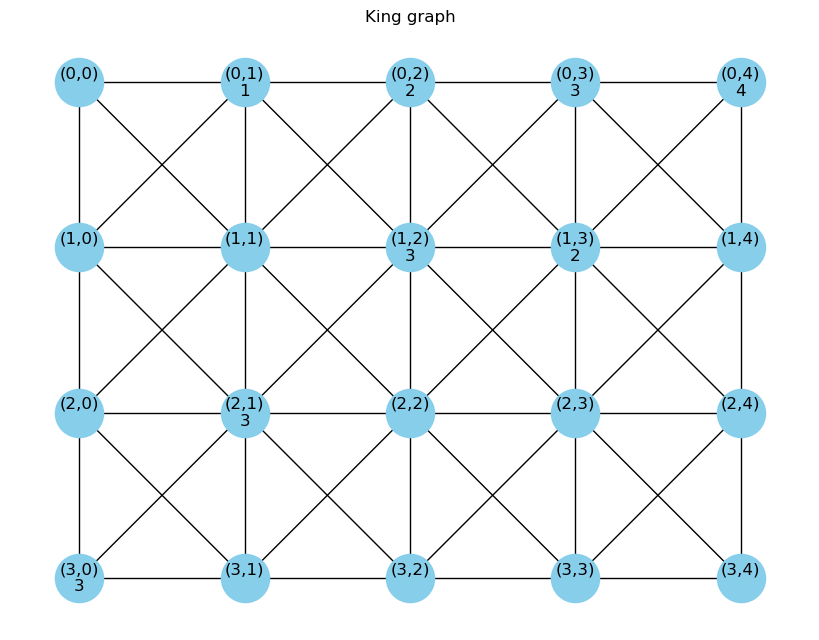

[1, 2, 4]
defaultdict(<class 'list'>, {1: [(0, 1)], 2: [(0, 2), (1, 3)], 3: [(0, 3), (1, 2), (2, 1), (3, 0)], 4: [(0, 4)]})
<class 'collections.defaultdict'>


In [51]:
import networkx as nx
from collections import deque, defaultdict
import matplotlib.pyplot as plt

###############################################################
# 無向グラフの描画
def Show_Graph(H):
    # PyGraphvizのcircoレイアウトを使用してノードの位置を計算
    pos = nx.drawing.nx_agraph.graphviz_layout(H, prog='circo')

    plt.figure(figsize=(6, 4))
    nx.draw(H, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=14, font_color='black')
    plt.title('Graph H (Fig. 4(a) in the paper')
    plt.show()

###############################################################
# 格子状レイアウトでキンググラフを描画
def Show_KingGraph(G):
    # yを横、-xを縦にすることで正しい表現（行, 列）になる
    pos = {(x, y): (y, -x) for x, y in G.nodes()}

    # ノードラベルを設定
    # labels = {(x, y): f"({x},{y})" for x, y in G.nodes()}
    labels = {(x, y): f"({x},{y})\n{G.nodes[(x, y)]['val']}" for x, y in G.nodes()}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1200, node_color='skyblue', font_size=12, font_color='black')
    plt.title('King graph')
    plt.show()

def set_node_val(G, node, val):
    G.nodes[node]['val'] = val

def get_val_nodes(G, val):
    return [node for node, data in G.nodes(data=True) if data.get('val') == val]

###############################################################
def mVG(G, subG, nodes):
    # 初期化
    val_nodes = defaultdict(list) # val値を持つノードのリスト
    for node in G.nodes():
        val = G.nodes[node].get('val')
        if val:
            val_nodes[val].append(node)
    
    # 距離テーブルの作成
    distance_table = defaultdict(lambda: defaultdict(lambda: float('inf')))
    for node in nodes:
        val = node  # nodes の要素自体が H のノードなので、そのまま val として使用
        phi_v = val_nodes[val]  # G の頂点集合 \phi(v)
        queue = deque([(v, 0) for v in phi_v if v in subG])
        visited = set(phi_v)
        while queue:
            current_node, dist = queue.popleft()
            distance_table[node][current_node] = dist
            for neighbor in subG.neighbors(current_node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + 1))
    
    # 経路長に基づく最短距離を持つ頂点を探す
    for dist in range(1, subG.number_of_nodes() + 1):
        for node in nodes:
            val = node  # nodes の要素自体が H のノードなので、そのまま val として使用
            phi_v = val_nodes[val]  # G の頂点集合 \phi(v)
            for val_node in phi_v:
                if distance_table[node][val_node] == dist:
                    v_star = val_node
                    break
            else:
                continue
            break
        else:
            continue
        break
    
    # \xi の構築
    xi = {v_star}
    for node in nodes:
        val = node  # nodes の要素自体が H のノードなので、そのまま val として使用
        phi_v = val_nodes[val]  # G の頂点集合 \phi(v)
        for val_node in phi_v:
            if val_node in subG:
                shortest_path = nx.shortest_path(subG, source=v_star, target=val_node)
                xi.update(shortest_path)
    
    return xi

###############################################################
# main文に相当する部分

###############################################################
# 論文の図4(a)のグラフ

H = nx.Graph()  # 無向グラフ (Undirected Graph)
H.add_nodes_from([0, 1, 2, 3, 4])
H.add_edges_from([(0,1), (0,2), (0,4), (1,2), (2,3), (2,4), (3,4)])

n = H.number_of_nodes()   # グラフHのノード数
H_nodes = list(H.nodes()) # グラフHのノードリスト
# Show_Graph(H)

###############################################################
# (n-1)xn のキンググラフG

G = nx.grid_2d_graph(n-1, n)
    
# 斜め方向のエッジを追加
for x, y in G.nodes():
    if (x+1, y+1) in G.nodes():
        G.add_edge((x, y), (x+1, y+1))
    if (x+1, y-1) in G.nodes():
        G.add_edge((x, y), (x+1, y-1))

for x, y in G.nodes():
    set_node_val(G, (x, y), '')

set_node_val(G, (0, 1), 1)
set_node_val(G, (0, 2), 2)
set_node_val(G, (0, 3), 3)
set_node_val(G, (0, 4), 4)

set_node_val(G, (1, 2), 3)
set_node_val(G, (1, 3), 2)

set_node_val(G, (2, 1), 3)
set_node_val(G, (3, 0), 3)

Show_KingGraph(G)

subG_nodes = [node for node, data in G.nodes(data=True) if data.get('val') == '']
subG = G.subgraph(subG_nodes).copy()
# Show_KingGraph(subG)

# nodes を H.neighbors(H_nodes[0]) で設定
nodes = list(H.neighbors(H_nodes[0]))
print(nodes)

val_nodes = defaultdict(list)
for node in G.nodes():
    val = G.nodes[node].get('val')
    if val:
        val_nodes[val].append(node)
print(val_nodes)

distance_table = defaultdict(lambda: defaultdict(lambda: float('inf')))
# phi_v の集合を構築
phi_v_set = set()
for node in nodes:
    val = node
    phi_v = [v for v in val_nodes[val] if v in G]
    phi_v_set.update(phi_v)

# 各 subG の頂点から phi_v のいずれかの頂点への最短距離を計算
for start_node in subG.nodes():
    queue = deque([(start_node, 0)])
    visited = set()
    visited.add(start_node)
    
    while queue:
        current_node, dist = queue.popleft()
        
        # phi_v の中で現在のノードに対応するものがあれば最短距離を更新
        for val_node in phi_v_set:
            if current_node == val_node:
                distance_table[start_node][current_node] = dist
                break
        
        for neighbor in subG.neighbors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, dist + 1))

# このコードでは distance_table は空になる

print(type(distance_table))
for start_node, distances in distance_table.items():
    print(f"From node {start_node}:")
    for end_node, distance in distances.items():
        print(f"  Distance to node {end_node}: {distance}")
        
# for node in nodes:
#     print(f"Node {node}:")   
#     for target, dist in distance_table[node].items():
#         print(f"  {target}: {dist}")

# result = mVG(G, subG, nodes)
# print(result)